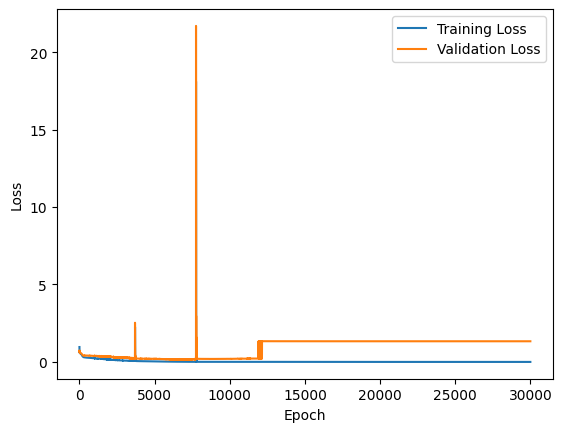

Confusion Matrix:
[[112   3]
 [  0 110]]
Accuracy: 98.66666666666667 %
F1 Score: 0.9865470852017937


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Definindo a arquitetura da rede neural
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

# Carregando os dados
filepath_train = "/content/data_train.csv"
filepath_test = "/content/data_test.csv"
data_train = pd.read_csv(filepath_train).drop(columns=["Unnamed: 0"])
data_test = pd.read_csv(filepath_test).drop(columns=["Unnamed: 0"])

# Separando features e labels
X_train = torch.tensor(data_train.drop(columns=["13"]).values, dtype=torch.float32)
y_train = torch.tensor(data_train["13"].values, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(data_test.drop(columns=["13"]).values, dtype=torch.float32)
y_test = torch.tensor(data_test["13"].values, dtype=torch.float32).view(-1, 1)

# Inicializando o modelo
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Definindo a função de custo e o otimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listas para armazenar os valores de perda e acurácia
train_losses = []
val_losses = []

# Treinamento do modelo
num_epochs = 30*1000
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validando o modelo
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "./best_model.pt")

# Carregando o melhor modelo
model.load_state_dict(torch.load("./best_model.pt"))

# Plotando as curvas de aprendizado
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testando o modelo
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = (test_outputs > 0.5).float()
    cm = confusion_matrix(y_test.numpy(), test_preds.numpy())
    accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
    f1 = f1_score(y_test.numpy(), test_preds.numpy())

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy*100} %")
print("F1 Score:", f1)
